# Assignment 10 - Viraj Noorithaya


## Library Installation (Optional)


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    import sys
    !{sys.executable} -m pip install torchsummary

    # if model_run_location == 'colab':
    #     !{sys.executable} -m pip install albumentations

    # # Needed locally
    # !conda install -c conda-forge tqdm
    # !conda install -c anaconda ipywidgets

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations


## Mount Drive


In [3]:
# Mount google drive if running on colab
if model_run_location == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 09/Submission

Mounted at /content/drive
/content/drive/MyDrive/WorkSpace/era-v1/Session 09/Submission


## Import Libraries


In [4]:
# Import necessary modules (external libs)
import os

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim

from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary

In [5]:
# Import user defined modules
from modules.dataset import split_cifar_data, apply_cifar_image_transformations
from modules.dataset import CIFAR_MEAN, CIFAR_STD
from modules.custom_resnet import CustomResNet as Net
from modules.trainer import test_model, train_model
from modules.utils import get_device, save_model
from modules.visualize import (
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

## Script Parameters


In [ ]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Specify the number of epochs
NUM_EPOCHS = 24

# Set the batch size
BATCH_SIZE = 512

# Set seed value for reproducibility
SEED = 8

# Expected accuracy
TARGET_ACCURACY = 90.0

## Get Device

In [6]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()
print(f"Device created with {device_support}!")

Device created with cuda!


## Data Transformations


In [7]:
# Train and test data transformation steps now moved to apply_mnist_image_transformations()

# cutout needs to be half of the image size
cutout_size = 16

train_transforms, test_transforms = apply_cifar_image_transformations(
    mean=CIFAR_MEAN, std=CIFAR_STD, cutout_size=cutout_size
)

## Train/Test Split


In [8]:
data_path = "../../data"
print(f"Train and test data path: {data_path}")

train_data, test_data = split_cifar_data(data_path, train_transforms, test_transforms)

Train and test data path: ../../data

Files already downloaded and verified
Files already downloaded and verified

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]

Transforms applied on the dataset



## Dataloaders


In [ ]:
# For reproducibility
torch.manual_seed(SEED)

if device_support == "cuda":
    torch.cuda.manual_seed(SEED)

# calculate the number of workers
num_workers = (os.cpu_count() - 1) if os.cpu_count() > 3 else 2

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(
    shuffle=True, BATCH_SIZE=BATCH_SIZE, num_workers=num_workers, pin_memory=True
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

In [ ]:
# Create class labels
classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Convert classes to propercase
classes = tuple([c.capitalize() for c in classes])
print(classes)

('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


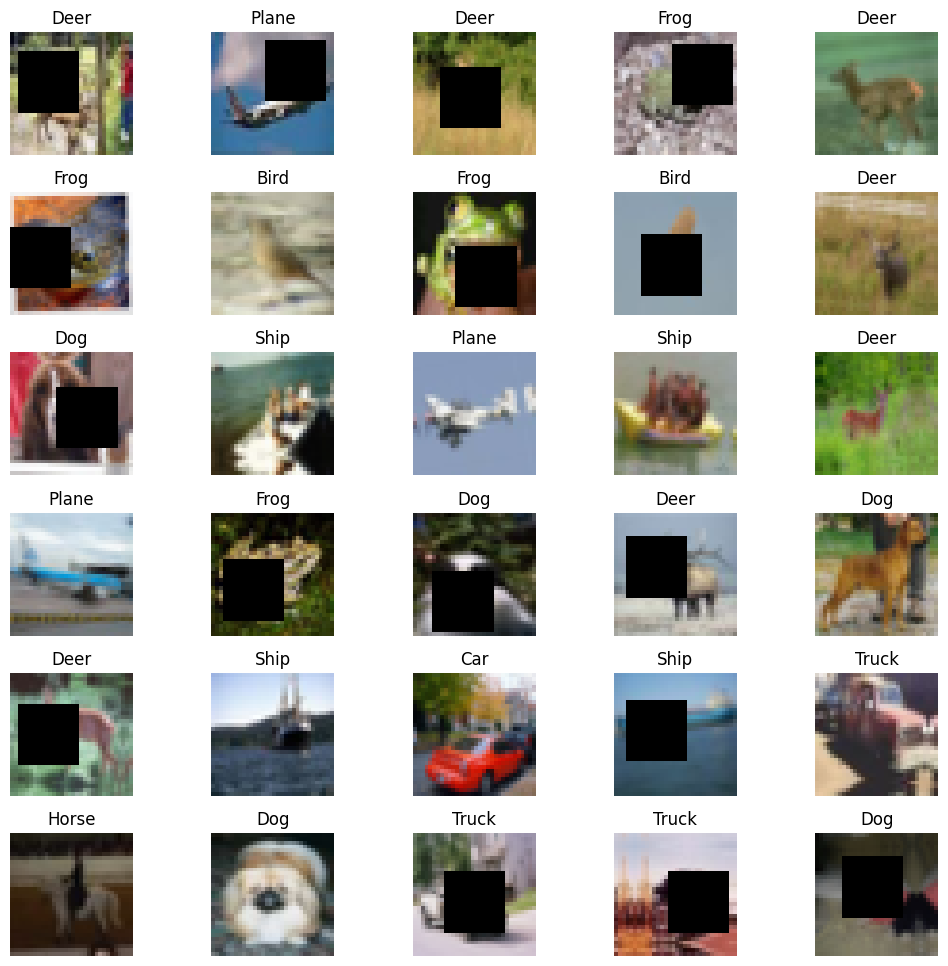

In [ ]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(
    batch_data, batch_label, class_label=classes, num_images=30
)
plt.show()

## Model Summary


In [ ]:
# Model class is imported from model.py

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# Print the model summary by specifying the input size
summary(model, input_size=(3, 32, 32))

# disable printing shape for cleaner test train output
model.print_shape = False

torch.Size([2, 12, 32, 32])
torch.Size([2, 24, 16, 16])
torch.Size([2, 32, 16, 16])
torch.Size([2, 64, 14, 14])
torch.Size([2, 64, 1, 1])
torch.Size([2, 64])
torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
           Dropout-3            [-1, 8, 32, 32]               0
       BatchNorm2d-4            [-1, 8, 32, 32]              16
            Conv2d-5            [-1, 8, 32, 32]             576
              ReLU-6            [-1, 8, 32, 32]               0
           Dropout-7            [-1, 8, 32, 32]               0
       BatchNorm2d-8            [-1, 8, 32, 32]              16
            Conv2d-9           [-1, 12, 32, 32]             864
             ReLU-10           [-1, 12, 32, 32]               0
          Dropout-11           [-1, 12, 32, 32]      

## Metric Initialisation


In [ ]:
# Data to plot accuracy and loss graphs

# Hold test and train losses in a list
train_losses = []
test_losses = []
# Hold test and train accuracies in a list
train_acc = []
test_acc = []
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

## Train and Test


In [ ]:

# Create optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define criteria function
criterion = F.nll_loss

# # Learning rate scheduler based on plateau
# # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
# scheduler = ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.5, patience=1, threshold=0.03, verbose=False
# )

# Learning rate scheduler based on  OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.1,
    steps_per_epoch=len(train_data),
    epochs=NUM_EPOCHS,
    verbose=False,
)

print(f"\n\nBatch size: {BATCH_SIZE}, Total epochs: {NUM_EPOCHS}\n\n")
# Run the model for NUM_EPOCHS
for epoch in range(1, NUM_EPOCHS + 1):
    # Print the current epoch
    print(f"Epoch {epoch}")

    # Train the model
    train_model(
        model, device, train_loader, optimizer, criterion, train_acc, train_losses
    )

    # Test the model
    test_model(
        model,
        device,
        test_loader,
        criterion,
        test_acc,
        test_losses,
        misclassified_image_data,
    )

    # Check if the accuracy is the best accuracy till now
    # Save the model if you get the best test accuracy
    if max(test_acc) == test_acc[-1]:
        print("Saving the model as best test accuracy till now is achieved!")
        save_model(
            epoch,
            model,
            optimizer,
            scheduler,
            BATCH_SIZE,
            criterion,
            file_name="model_best_epoch.pth",
        )

    # # Passing the latest test loss in list to scheduler to adjust learning rate
    # scheduler.step(test_losses[-1])
    scheduler.step()
    # # # Line break before next epoch
    print("\n")



Batch size: 128, Total epochs: 50


Epoch 1


Train: Loss=1.5597, Batch_id=390, Accuracy=31.35: 100%|██████████| 391/391 [00:18<00:00, 21.66it/s]


Test set: Average loss: 1.4526, Accuracy: 4500/10000 (45.00%)
Saving the model as best test accuracy till now is achieved!


Epoch 2


Train: Loss=1.2169, Batch_id=390, Accuracy=46.21: 100%|██████████| 391/391 [00:19<00:00, 20.34it/s]


Test set: Average loss: 1.1890, Accuracy: 5625/10000 (56.25%)
Saving the model as best test accuracy till now is achieved!


Epoch 3


Train: Loss=1.4035, Batch_id=390, Accuracy=53.05: 100%|██████████| 391/391 [00:18<00:00, 21.67it/s]


Test set: Average loss: 1.0611, Accuracy: 6156/10000 (61.56%)
Saving the model as best test accuracy till now is achieved!


Epoch 4


Train: Loss=1.1002, Batch_id=390, Accuracy=57.50: 100%|██████████| 391/391 [00:18<00:00, 21.38it/s]


Test set: Average loss: 0.9679, Accuracy: 6490/10000 (64.90%)
Saving the model as best test accuracy till now is achieved!


Epoch 5


Train: Loss=0.9335, Batch_id=390, Accuracy=59.93: 100%|██████████| 391/391 [00:18<00:00, 21.44it/s]


Test set: Average loss: 0.8628, Accuracy: 6901/10000 (69.01%)
Saving the model as best test accuracy till now is achieved!


Epoch 6


Train: Loss=1.0514, Batch_id=390, Accuracy=62.66: 100%|██████████| 391/391 [00:19<00:00, 20.26it/s]


Test set: Average loss: 0.8053, Accuracy: 7148/10000 (71.48%)
Saving the model as best test accuracy till now is achieved!


Epoch 7


Train: Loss=1.0892, Batch_id=390, Accuracy=64.87: 100%|██████████| 391/391 [00:18<00:00, 21.18it/s]


Test set: Average loss: 0.7648, Accuracy: 7350/10000 (73.50%)
Saving the model as best test accuracy till now is achieved!


Epoch 8


Train: Loss=0.9545, Batch_id=390, Accuracy=65.97: 100%|██████████| 391/391 [00:17<00:00, 22.25it/s]


Test set: Average loss: 0.7306, Accuracy: 7434/10000 (74.34%)
Saving the model as best test accuracy till now is achieved!


Epoch 9


Train: Loss=0.8904, Batch_id=390, Accuracy=67.65: 100%|██████████| 391/391 [00:19<00:00, 20.38it/s]


Test set: Average loss: 0.7105, Accuracy: 7572/10000 (75.72%)
Saving the model as best test accuracy till now is achieved!


Epoch 10


Train: Loss=0.9085, Batch_id=390, Accuracy=68.46: 100%|██████████| 391/391 [00:17<00:00, 22.37it/s]


Test set: Average loss: 0.6643, Accuracy: 7662/10000 (76.62%)
Saving the model as best test accuracy till now is achieved!


Epoch 11


Train: Loss=0.7089, Batch_id=390, Accuracy=69.72: 100%|██████████| 391/391 [00:17<00:00, 21.88it/s]


Test set: Average loss: 0.6653, Accuracy: 7744/10000 (77.44%)
Saving the model as best test accuracy till now is achieved!


Epoch 12


Train: Loss=0.9395, Batch_id=390, Accuracy=70.12: 100%|██████████| 391/391 [00:17<00:00, 22.41it/s]


Test set: Average loss: 0.6278, Accuracy: 7815/10000 (78.15%)
Saving the model as best test accuracy till now is achieved!


Epoch 13


Train: Loss=0.8052, Batch_id=390, Accuracy=70.67: 100%|██████████| 391/391 [00:17<00:00, 21.98it/s]


Test set: Average loss: 0.6024, Accuracy: 7891/10000 (78.91%)
Saving the model as best test accuracy till now is achieved!


Epoch 14


Train: Loss=0.5834, Batch_id=390, Accuracy=71.54: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]


Test set: Average loss: 0.6056, Accuracy: 7895/10000 (78.95%)
Saving the model as best test accuracy till now is achieved!


Epoch 15


Train: Loss=0.6659, Batch_id=390, Accuracy=72.09: 100%|██████████| 391/391 [00:17<00:00, 21.79it/s]


Test set: Average loss: 0.5692, Accuracy: 8030/10000 (80.30%)
Saving the model as best test accuracy till now is achieved!


Epoch 16


Train: Loss=0.7767, Batch_id=390, Accuracy=72.68: 100%|██████████| 391/391 [00:20<00:00, 19.35it/s]


Test set: Average loss: 0.5579, Accuracy: 8067/10000 (80.67%)
Saving the model as best test accuracy till now is achieved!


Epoch 17


Train: Loss=1.1557, Batch_id=390, Accuracy=73.00: 100%|██████████| 391/391 [00:17<00:00, 22.13it/s]


Test set: Average loss: 0.5553, Accuracy: 8102/10000 (81.02%)
Saving the model as best test accuracy till now is achieved!


Epoch 18


Train: Loss=0.8029, Batch_id=390, Accuracy=73.31: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]


Test set: Average loss: 0.5481, Accuracy: 8139/10000 (81.39%)
Saving the model as best test accuracy till now is achieved!


Epoch 19


Train: Loss=1.0237, Batch_id=390, Accuracy=73.99: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s]


Test set: Average loss: 0.5240, Accuracy: 8177/10000 (81.77%)
Saving the model as best test accuracy till now is achieved!


Epoch 20


Train: Loss=0.7743, Batch_id=390, Accuracy=74.17: 100%|██████████| 391/391 [00:17<00:00, 22.01it/s]


Test set: Average loss: 0.5315, Accuracy: 8199/10000 (81.99%)
Saving the model as best test accuracy till now is achieved!


Epoch 21


Train: Loss=0.7171, Batch_id=390, Accuracy=74.81: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]


Test set: Average loss: 0.5237, Accuracy: 8199/10000 (81.99%)
Saving the model as best test accuracy till now is achieved!


Epoch 22


Train: Loss=0.7938, Batch_id=390, Accuracy=74.77: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]


Test set: Average loss: 0.5080, Accuracy: 8276/10000 (82.76%)
Saving the model as best test accuracy till now is achieved!


Epoch 23


Train: Loss=0.7894, Batch_id=390, Accuracy=75.20: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s]


Test set: Average loss: 0.5058, Accuracy: 8270/10000 (82.70%)


Epoch 24


Train: Loss=0.6595, Batch_id=390, Accuracy=75.50: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]


Test set: Average loss: 0.5021, Accuracy: 8296/10000 (82.96%)
Saving the model as best test accuracy till now is achieved!


Epoch 25


Train: Loss=0.7422, Batch_id=390, Accuracy=75.61: 100%|██████████| 391/391 [00:19<00:00, 20.20it/s]


Test set: Average loss: 0.5182, Accuracy: 8236/10000 (82.36%)


Epoch 26


Train: Loss=0.6681, Batch_id=390, Accuracy=75.94: 100%|██████████| 391/391 [00:17<00:00, 21.98it/s]


Test set: Average loss: 0.4924, Accuracy: 8343/10000 (83.43%)
Saving the model as best test accuracy till now is achieved!


Epoch 27


Train: Loss=0.6314, Batch_id=390, Accuracy=76.22: 100%|██████████| 391/391 [00:17<00:00, 21.86it/s]


Test set: Average loss: 0.4885, Accuracy: 8319/10000 (83.19%)


Epoch 28


Train: Loss=0.7291, Batch_id=390, Accuracy=76.12: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]


Test set: Average loss: 0.4778, Accuracy: 8381/10000 (83.81%)
Saving the model as best test accuracy till now is achieved!


Epoch 29


Train: Loss=0.6909, Batch_id=390, Accuracy=76.48: 100%|██████████| 391/391 [00:17<00:00, 22.06it/s]


Test set: Average loss: 0.4737, Accuracy: 8399/10000 (83.99%)
Saving the model as best test accuracy till now is achieved!


Epoch 30


Train: Loss=0.8150, Batch_id=390, Accuracy=76.63: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s]


Test set: Average loss: 0.4622, Accuracy: 8440/10000 (84.40%)
Saving the model as best test accuracy till now is achieved!


Epoch 31


Train: Loss=0.6408, Batch_id=390, Accuracy=76.69: 100%|██████████| 391/391 [00:17<00:00, 22.18it/s]


Test set: Average loss: 0.4727, Accuracy: 8418/10000 (84.18%)


Epoch 32


Train: Loss=0.9029, Batch_id=390, Accuracy=76.94: 100%|██████████| 391/391 [00:18<00:00, 21.32it/s]


Test set: Average loss: 0.4735, Accuracy: 8400/10000 (84.00%)


Epoch 33


Train: Loss=0.7119, Batch_id=390, Accuracy=77.10: 100%|██████████| 391/391 [00:18<00:00, 21.06it/s]


Test set: Average loss: 0.4582, Accuracy: 8457/10000 (84.57%)
Saving the model as best test accuracy till now is achieved!


Epoch 34


Train: Loss=0.5997, Batch_id=390, Accuracy=77.32: 100%|██████████| 391/391 [00:17<00:00, 22.12it/s]


Test set: Average loss: 0.4629, Accuracy: 8445/10000 (84.45%)


Epoch 35


Train: Loss=0.8371, Batch_id=390, Accuracy=77.37: 100%|██████████| 391/391 [00:21<00:00, 18.29it/s]


Test set: Average loss: 0.4611, Accuracy: 8410/10000 (84.10%)


Epoch 36


Train: Loss=0.6587, Batch_id=390, Accuracy=77.72: 100%|██████████| 391/391 [00:18<00:00, 21.30it/s]


Test set: Average loss: 0.4482, Accuracy: 8461/10000 (84.61%)
Saving the model as best test accuracy till now is achieved!


Epoch 37


Train: Loss=0.5546, Batch_id=390, Accuracy=77.69: 100%|██████████| 391/391 [00:18<00:00, 21.28it/s]


Test set: Average loss: 0.4396, Accuracy: 8531/10000 (85.31%)
Saving the model as best test accuracy till now is achieved!


Epoch 38


Train: Loss=0.5891, Batch_id=390, Accuracy=77.72: 100%|██████████| 391/391 [00:18<00:00, 21.71it/s]


Test set: Average loss: 0.4411, Accuracy: 8527/10000 (85.27%)


Epoch 39


Train: Loss=0.4353, Batch_id=390, Accuracy=78.04: 100%|██████████| 391/391 [00:17<00:00, 22.08it/s]


Test set: Average loss: 0.4384, Accuracy: 8520/10000 (85.20%)


Epoch 40


Train: Loss=0.5473, Batch_id=390, Accuracy=77.93: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s]


Test set: Average loss: 0.4431, Accuracy: 8519/10000 (85.19%)


Epoch 41


Train: Loss=0.6322, Batch_id=390, Accuracy=78.36: 100%|██████████| 391/391 [00:17<00:00, 21.82it/s]


Test set: Average loss: 0.4303, Accuracy: 8536/10000 (85.36%)
Saving the model as best test accuracy till now is achieved!


Epoch 42


Train: Loss=0.6371, Batch_id=390, Accuracy=78.56: 100%|██████████| 391/391 [00:19<00:00, 20.04it/s]


Test set: Average loss: 0.4386, Accuracy: 8506/10000 (85.06%)


Epoch 43


Train: Loss=0.5805, Batch_id=390, Accuracy=78.52: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]


Test set: Average loss: 0.4211, Accuracy: 8559/10000 (85.59%)
Saving the model as best test accuracy till now is achieved!


Epoch 44


Train: Loss=0.4752, Batch_id=390, Accuracy=78.65: 100%|██████████| 391/391 [00:21<00:00, 18.35it/s]


Test set: Average loss: 0.4355, Accuracy: 8562/10000 (85.62%)
Saving the model as best test accuracy till now is achieved!


Epoch 45


Train: Loss=0.6549, Batch_id=390, Accuracy=78.65: 100%|██████████| 391/391 [00:17<00:00, 21.94it/s]


Test set: Average loss: 0.4277, Accuracy: 8554/10000 (85.54%)


Epoch 46


Train: Loss=0.6392, Batch_id=390, Accuracy=78.91: 100%|██████████| 391/391 [00:18<00:00, 20.73it/s]


Test set: Average loss: 0.4219, Accuracy: 8579/10000 (85.79%)
Saving the model as best test accuracy till now is achieved!


Epoch 47


Train: Loss=0.5987, Batch_id=390, Accuracy=79.14: 100%|██████████| 391/391 [00:17<00:00, 21.92it/s]


Test set: Average loss: 0.4081, Accuracy: 8636/10000 (86.36%)
Saving the model as best test accuracy till now is achieved!


Epoch 48


Train: Loss=0.5647, Batch_id=390, Accuracy=79.20: 100%|██████████| 391/391 [00:18<00:00, 21.63it/s]


Test set: Average loss: 0.4262, Accuracy: 8561/10000 (85.61%)


Epoch 49


Train: Loss=0.6926, Batch_id=390, Accuracy=79.12: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s]


Test set: Average loss: 0.4146, Accuracy: 8588/10000 (85.88%)


Epoch 50


Train: Loss=0.6054, Batch_id=390, Accuracy=79.16: 100%|██████████| 391/391 [00:18<00:00, 21.26it/s]


Test set: Average loss: 0.4229, Accuracy: 8556/10000 (85.56%)




In [ ]:
# Pretty print train and test accuracy and loss values for each epoch
for i in range(NUM_EPOCHS):
    print(
        f"Epoch: {i+1:02d}, Train Loss: {train_losses[i]:.4f}, Test Loss: {test_losses[i]:.4f}, Train Accuracy: {train_acc[i]:.4f}, Test Accuracy: {test_acc[i]:.4f}"
    )

Epoch: 01, Train Loss: 1.8093, Test Loss: 1.4526, Train Accuracy: 31.3480, Test Accuracy: 45.0000
Epoch: 02, Train Loss: 1.4599, Test Loss: 1.1890, Train Accuracy: 46.2100, Test Accuracy: 56.2500
Epoch: 03, Train Loss: 1.2905, Test Loss: 1.0611, Train Accuracy: 53.0500, Test Accuracy: 61.5600
Epoch: 04, Train Loss: 1.1811, Test Loss: 0.9679, Train Accuracy: 57.4960, Test Accuracy: 64.9000
Epoch: 05, Train Loss: 1.1116, Test Loss: 0.8628, Train Accuracy: 59.9320, Test Accuracy: 69.0100
Epoch: 06, Train Loss: 1.0454, Test Loss: 0.8053, Train Accuracy: 62.6620, Test Accuracy: 71.4800
Epoch: 07, Train Loss: 0.9891, Test Loss: 0.7648, Train Accuracy: 64.8740, Test Accuracy: 73.5000
Epoch: 08, Train Loss: 0.9533, Test Loss: 0.7306, Train Accuracy: 65.9680, Test Accuracy: 74.3400
Epoch: 09, Train Loss: 0.9186, Test Loss: 0.7105, Train Accuracy: 67.6480, Test Accuracy: 75.7200
Epoch: 10, Train Loss: 0.8936, Test Loss: 0.6643, Train Accuracy: 68.4600, Test Accuracy: 76.6200
Epoch: 11, Train Los

## Metrics


Expected accuracy: 85.0%
Plotting accuracy and loss graphs.


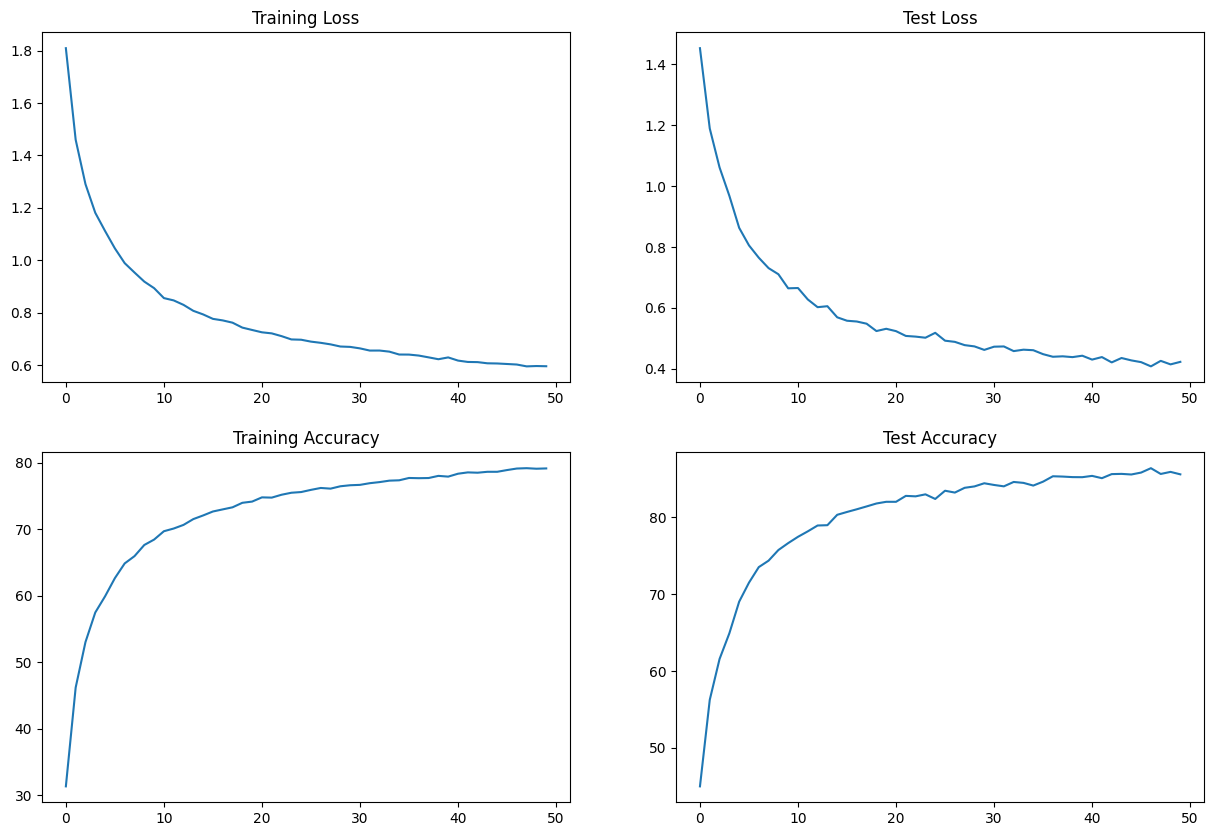

In [ ]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {TARGET_ACCURACY}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(train_losses, train_acc, test_losses, test_acc)
plt.show()

## Save model


In [ ]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch,
    model,
    optimizer,
    scheduler,
    BATCH_SIZE,
    criterion,
    file_name="model_last_epoch.pth",
)

Saving the model as the training is complete!


## Show incorrect images


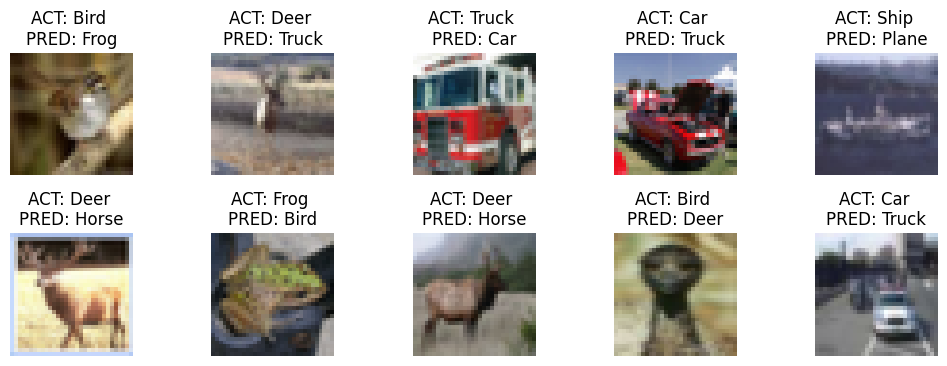

In [ ]:
# Plot misclassified images
fig, axs = plot_misclassified_images(
    data=misclassified_image_data, class_label=classes, num_images=10
)
plt.show()